In [1]:
%run ../base_setup.ipynb

Foundation: 2.09.024
Transition: 2.09.022
Engines   : 2.03.015
Behavioral: 2.04.016


-------------------------
## Build Flu Risk raw synthetic file

In [2]:
builder = SyntheticBuilder.from_env('risk_score')

In [3]:
tools = builder.intent_model

In [4]:
builder.pm.reset_intents()
builder.pm_persist()

In [5]:
# Get the columns from the Members file
df = builder.intent_model.model_columns(connector_name=builder.CONNECTOR_SOURCE, headers=['member_id', 'state', 'flu_shot', 'latent_has_children', 'latent_has_travelled', 'age'], column_name='member_reference')
builder.add_column_description(column_name='member_reference', description="member reference data taken from the synthetic Members distribution")

In [6]:
sample_size = df.shape[0]

--------------------------

In [7]:
# conditional latent privilage for age under 40
selection = [builder.tools.select2dict(column='age', condition='<=40')]

action = builder.tools.action2dict(method='get_number', range_value=-0.1, to_value=0.1, precision=1, weight_pattern=[20, 1])
default = builder.tools.action2dict(method='get_number', range_value=-0.1, to_value=0.2, precision=1, weight_pattern=[3, 20, 1])

df['age_privilege'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='age_privilege', intent_order=0)
builder.add_column_description(column_name='age_privilege', description="set privilege for under 40 with reduced risk with default zero privilage")

In [8]:
# conditional latent privilage for age over 75
selection = [builder.tools.select2dict(column='age', condition='>75')]

action = builder.tools.action2dict(method='get_number', range_value=-0.1, to_value=0.3, precision=1, weight_pattern=[1, 99, 10])
default = builder.tools.action2dict(method='@header', header='age_privilege')

df['age_privilege'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='age_privilege', intent_order=1)
builder.add_column_description(column_name='age_privilege', description="set zero privilage for most over 75")

--------------------------

In [9]:
df['flu_risk_score'] = builder.tools.get_bounded_normal(mean=0.55, std=0.2, lower=0.001, upper=1, size=sample_size, column_name='flu_risk_score', intent_order=0)
builder.add_column_description(column_name='flu_risk_score', description="A generated flu risk score withg a bound normal distribution wth a mean of 0.55 and std of 0.2")

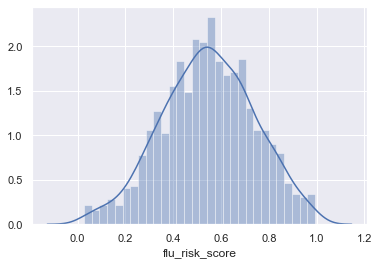

In [10]:
sns.set()
sns.distplot(df['flu_risk_score'], bins=30)

In [11]:
# had flu shot so low risk
selection = [tools.select2dict(column='flu_shot', condition="==1")]

action = tools.action2dict(method='get_bounded_normal', mean=0.1, std=0.1, lower=0.001, upper=0.4)
default = tools.action2dict(method='@header', header='flu_risk_score')

df['flu_risk_score'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='flu_risk_score', intent_order=1)
builder.add_column_description(column_name='flu_risk_score', description="normally distribute those with a flue-shot with a bound normal distribution, mean of 0.1 and std of 0.1 with an upper bound of 0.4")

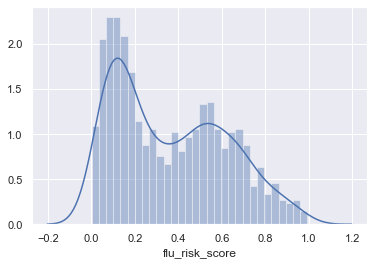

In [12]:
sns.set()
sns.distplot(df['flu_risk_score'], bins=30)

In [13]:
# adjust flu risk according to age privilage
selection = [tools.select2dict(column='age_privilege', condition=">0.1"),
             tools.select2dict(column='age', condition=">40", logic='OR')]

action = tools.action2dict(method='correlate_columns', headers=['flu_risk_score', 'age_privilege'], action='sum')
default = tools.action2dict(method='@header', header='flu_risk_score')

df['flu_risk_score'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='flu_risk_score', intent_order=2)
builder.add_column_description(column_name='flu_risk_score', description="add age_privilege to the risk score to adjust for the privilage of age")

In [14]:
# adjust to be in bounds of the range
selection = [tools.select2dict(column='flu_risk_score', condition=">=1")]

action = tools.action2dict(method='get_bounded_normal', mean=0.9, std=0.02, lower=0.8, upper=0.998)
default = tools.action2dict(method='@header', header='flu_risk_score')

df['flu_risk_score'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='flu_risk_score', intent_order=3)

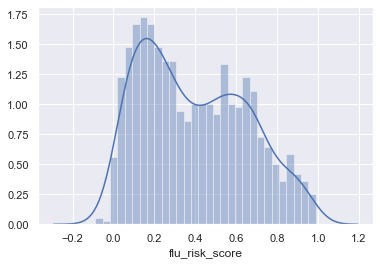

In [15]:
sns.set()
sns.distplot(df['flu_risk_score'], bins=30)

In [16]:
builder.run_synthetic_pipeline(size=sample_size)